# Virtual data set (VDS) reference file for SCATSAT1_ESDR_L2_WIND_STRESS_V1.1 using Virtualizarr

Saves VDS as parquet file. SCATSAT1_ESDR_L2_WIND_STRESS_V1.1 is an L2 data set with no time dimension, so this is an example of saving along a newly created dimension.

In [1]:
# Built-in packages
import os
import sys

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import pandas as pd

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import coiled

# Other
import matplotlib.pyplot as plt

## 1. Get Data File S3 endpoints in Earthdata Cloud

In [2]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [3]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [4]:
# Locate CCMP file information / metadata:
granule_info = earthaccess.search_data(
    short_name="SCATSAT1_ESDR_L2_WIND_STRESS_V1.1",
    )

In [5]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print(len(data_s3links))
data_s3links[0:3]

13145


['s3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08002_v1.1_s20180401-011908-e20180401-025826.nc',
 's3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08003_v1.1_s20180401-025826-e20180401-043745.nc',
 's3://podaac-ops-cumulus-protected/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/2018/091/measures_esdr_scatsat_l2_wind_stress_08004_v1.1_s20180401-043745-e20180401-061703.nc']

## 2. Generate single-orbit reference files

One file per orbit, so one reference file per orbit.

In [32]:
n_files_process = 1000

In [6]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set:
coord_vars = ["lat","lon"]

In [7]:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 16


In [8]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.

In [ ]:
# Start up cluster and print some information about it:
client = Client(n_workers=15, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

In [27]:
%%time
# Create individual references:
open_vds_par = delayed(open_virtual_dataset)
tasks = [
    open_vds_par(p, indexes={}, reader_options=reader_opts, loadable_variables=coord_vars) 
    for p in data_s3links[:n_files_process]
    ]
virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.

CPU times: user 25.8 s, sys: 6.64 s, total: 32.4 s
Wall time: 1min 51s


In [28]:
len(virtual_ds_list)

1000

## 3. Generate combined reference file along a newly created time dimension

The dimension will be "orbit start time", so get the start time from each file using the granule metadata. Convert those times into cf-compliant formats (e.g. "second since ..."). 

## 3.1 Create reference file

In [33]:
## The dimension will be "orbit start time", so get the start time from each file using the granule metadata:

basetime_str = "1970-01-01T00:00:00Z" # times will be measured in seconds since this basetime. 

orbit_starttime_list = []
for g in granule_info[:n_files_process]:
    datetime_str = g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']
    datetime_obj = np.datetime64(datetime_str)
    basetime_obj = np.datetime64(basetime_str)
    timedelt = np.timedelta64(datetime_obj - basetime_obj, 's').astype(int)
    orbit_starttime_list.append(timedelt)

/tmp/ipykernel_233/904977041.py:8: UserWarning: no explicit representation of timezones available for np.datetime64
  datetime_obj = np.datetime64(datetime_str)
/tmp/ipykernel_233/904977041.py:9: UserWarning: no explicit representation of timezones available for np.datetime64
  basetime_obj = np.datetime64(basetime_str)


In [34]:
## Wrap the orbit start time data in an xarray.DataArray, assigning CF-aligned attributes:
orbit_starttime_da = xr.DataArray(
    data=orbit_starttime_list,
    name="orbit_start_time",
    dims=["orbit_start_time"],
    attrs=dict(
        units="seconds since " + basetime_str,
        calendar = "gregorian"
    )
)

In [35]:
%%time
# Create the combined reference
virtual_ds_combined = xr.concat(virtual_ds_list, orbit_starttime_da, coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 4.55 s, sys: 32.8 ms, total: 4.59 s
Wall time: 4.51 s


In [52]:
virtual_ds_combined

<xarray.Dataset> Size: 64GB
Dimensions:                        (orbit_start_time: 1000, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB -89...
    lon                            (along_track, cross_track) float32 2MB 214...
  * orbit_start_time               (orbit_start_time) int64 8kB 1522545549 .....
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    real_wind_u_error              (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    flags                          (orbit_start_time, along_track, cross_track) int32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=int32, chunks=(1...
    quality_indicator              (orbit_start_time, along_track, cross_track) int16 987MB ManifestArray<shape=(1000, 3248, 152), dtype=int16, chunks=...
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    ...                             ...
    time                           (orbit_start_time, along_track) float64 26MB ManifestArray<shape=(1000, 3248), dtype=float64, chunks=(1, 324...
    en_wind_u_error                (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    en_wind_u                      (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    rain_speed_bias                (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
    nudge_wind_speed               (orbit_start_time, along_track, cross_track) float32 2GB ManifestArray<shape=(1000, 3248, 152), dtype=float32, chunks=...
Attributes: (12/28)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1
    coordinates:               lat lon orbit_start_time

In [53]:
# Save in JSON and PARQUET formats:
fname_combined_json = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-time.json'
fname_combined_parq = 'ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-time.parq'
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_parq, format='parquet')

## 3.2. Test reference file

Open data set using the reference file. Try out some temporal subsetting and taking the global mean of that subset

In [4]:
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

In [5]:
%%time
data = opends_withref('ref_combined_SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_concat-time.json', fs)
data

CPU times: user 400 ms, sys: 68.2 ms, total: 468 ms
Wall time: 796 ms


<xarray.Dataset> Size: 67GB
Dimensions:                        (orbit_start_time: 1000, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
    lon                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 8kB 2018...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 2GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [6]:
starttime = np.datetime64("2018-05-01T00:00:00") 
endtime = np.datetime64("2018-05-02T12:00:00")
data.sel(orbit_start_time=slice(starttime, endtime))

<xarray.Dataset> Size: 1GB
Dimensions:                        (orbit_start_time: 21, along_track: 3248,
                                    cross_track: 152)
Coordinates:
    lat                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
    lon                            (along_track, cross_track) float32 2MB dask.array<chunksize=(3248, 152), meta=np.ndarray>
  * orbit_start_time               (orbit_start_time) datetime64[ns] 168B 201...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_start_time, along_track, cross_track) float32 41MB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

In [10]:
%%time
#data.sel(orbit_start_time=slice(starttime, endtime))["real_wind_speed"].mean().compute()
ts = data.sel(orbit_start_time=slice(starttime, endtime))["real_wind_speed"].mean(dim=["along_track","cross_track"]).compute()

CPU times: user 258 ms, sys: 27.5 ms, total: 285 ms
Wall time: 578 ms


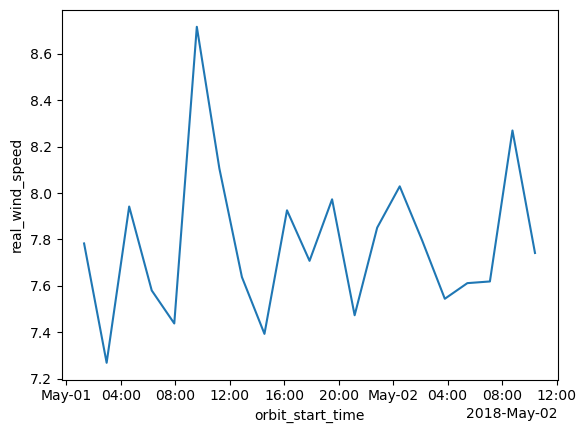

In [11]:
ts.plot()

## 4 Generate combined reference file along `along_track` dimension

So far, running the code to create the combined reference file hangs up indefinitely.

In [48]:
%%time
# Create the combined reference
virtual_ds_combined = xr.combine_nested(virtual_ds_list, concat_dim='along_track', coords='minimal', compat='override', combine_attrs='drop_conflicts')
#virtual_ds_combined = xr.concat(virtual_ds_list, 'along_track', coords='minimal', compat='override', combine_attrs='drop_conflicts')

Exception ignored in: <function File.close at 0x7f1d283bde40>
Traceback (most recent call last):
  File "/opt/coiled/env/lib/python3.12/site-packages/h5netcdf/core.py", line 1676, in close
    if not self._closed:
           ^^^^^^^^^^^^
AttributeError: 'File' object has no attribute '_closed'

KeyboardInterrupt



In [ ]:
virtual_ds_combined